In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
from src.evaluation import imbalanced_score, matthews_corrcoef_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from src.oversampling import G_SMOTEDecorator

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, AdaBoostClassifier,
    RandomForestClassifier, SVC 
    #GradientBoostingClassifier ExtraTreesClassifier
]

X = pd.read_csv('../data/all_X.csv')
y = pd.read_csv('../data/all_y.csv', header=None).T.ix[0]

i_train, i_test = next(StratifiedShuffleSplit(test_size=0.2, random_state=40).split(X, y))

X_train, X_test, y_train, y_test = X.loc[i_train], X.loc[i_test], y.loc[i_train], y.loc[i_test]

Using TensorFlow backend.


## Baseline

0.6901185770750988


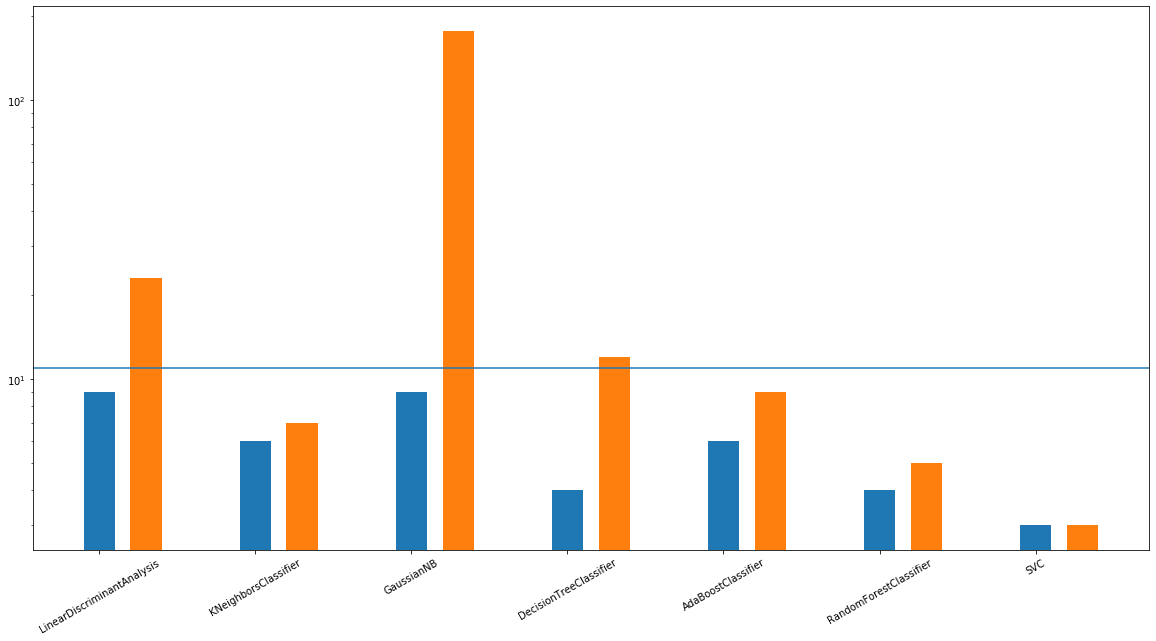

In [3]:
tps, ts, gts, labels, scores = [], [], [], [], []
for Model in models:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    tps.append(sum(y_test & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_test))
    labels.append(f'{Model.__name__}')
    scores.append(imbalanced_score(0.7)(clf, X_test, y_test))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

## Oversampler

2019-12-09 15:53:54,913:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 15:53:55,553:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 15:53:57,847:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 15:53:58,419:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 15:53:59,809:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-09 15:54:03,830:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}"

0.6729490022172949


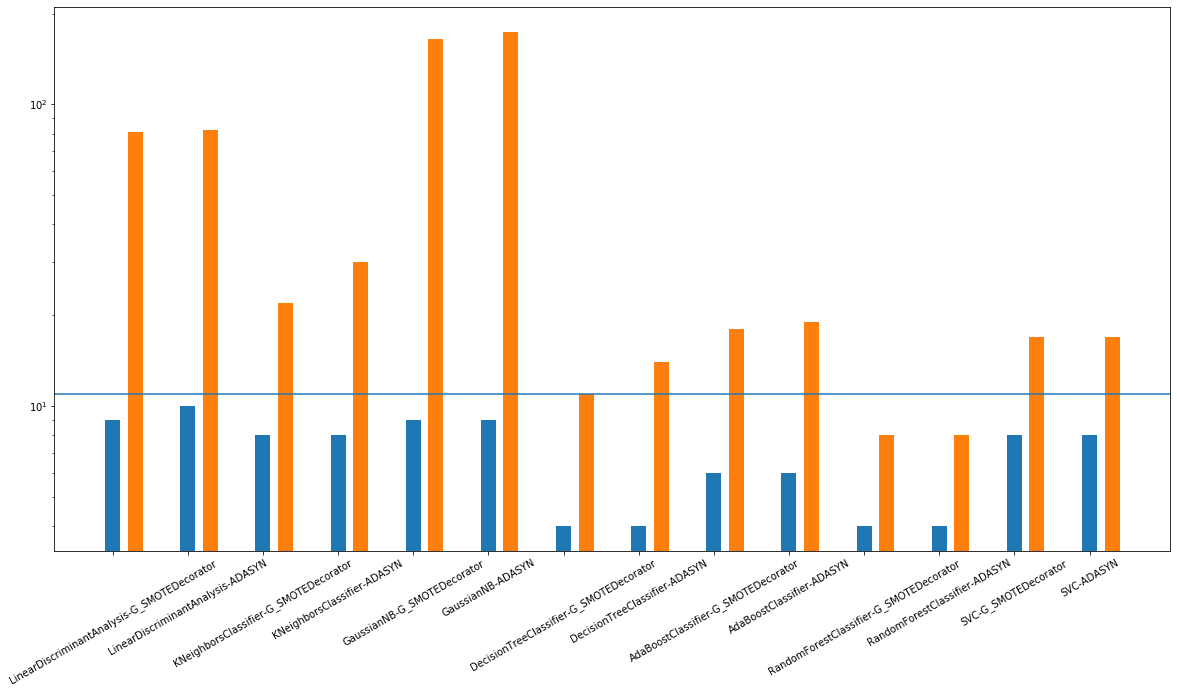

In [4]:
tps, ts, gts, labels, scores = [], [], [], [], []
for Model in models:
    for oversampler in [G_SMOTEDecorator(), ADASYN()]:
        pipeline = Pipeline([
            ('OVERSAMPLER', oversampler), (Model.__name__, Model())
        ])
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        tps.append(sum(y_test & y_pred))
        ts.append(sum(y_pred))
        gts.append(sum(y_test))
        labels.append(f'{Model.__name__}-{oversampler.__class__.__name__}')
        scores.append(imbalanced_score(0.7)(clf, X_test, y_test))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

## Hyper-Parameter tunning

0.7272619047619047


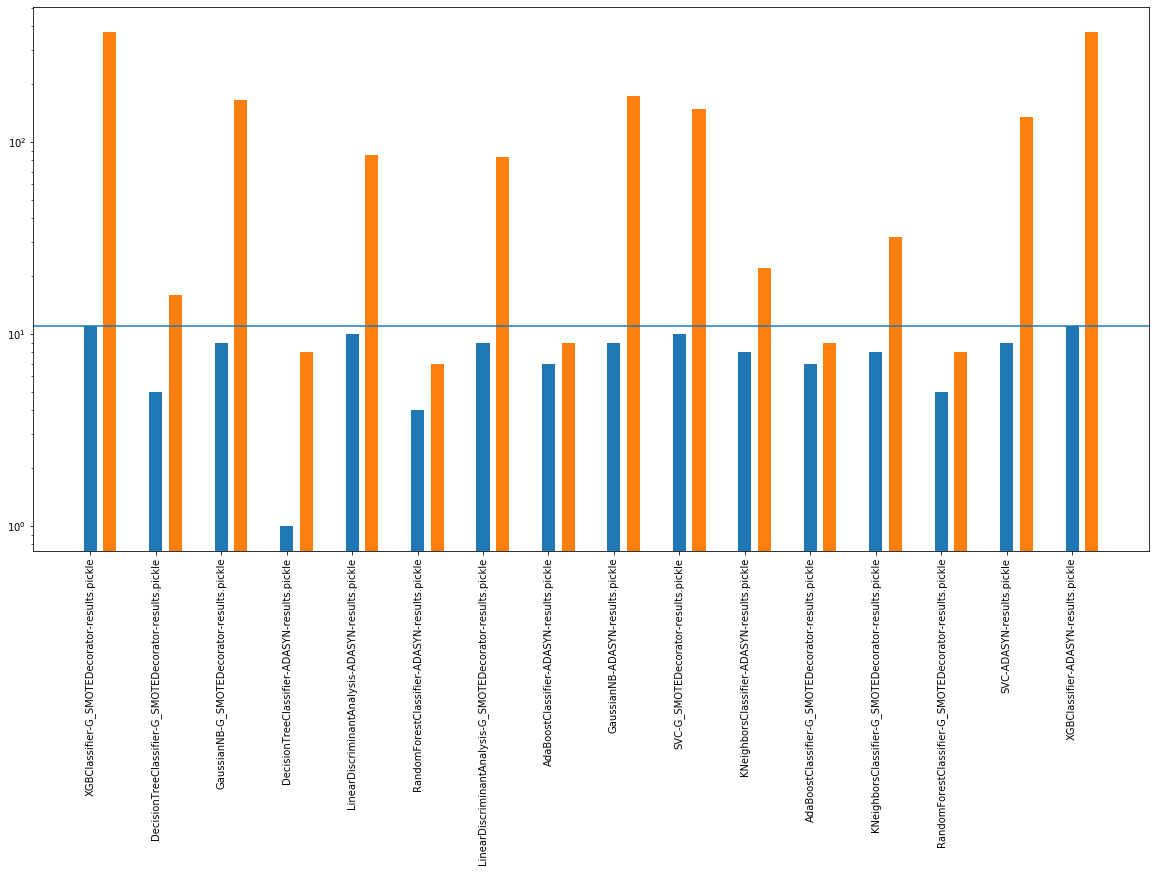

In [5]:
res_paths = glob('../experiments/model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels, scores = [], [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        res, y_true, y_pred = pickle.load(fh)
    res = pd.DataFrame(res)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)
    scores.append(res.mean_test_score.max())

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

{'FEATURE_SELECTION__n_features_to_select': 37}
{'FEATURE_SELECTION__n_features_to_select': 18}
{'FEATURE_SELECTION__n_features_to_select': 24}
{'FEATURE_SELECTION__n_features_to_select': 8}
{'FEATURE_SELECTION__n_features_to_select': 25}
{'FEATURE_SELECTION__n_features_to_select': 6}
{'FEATURE_SELECTION__n_features_to_select': 34}
{'FEATURE_SELECTION__n_features_to_select': 28}
{'FEATURE_SELECTION__n_features_to_select': 26}
{'FEATURE_SELECTION__n_features_to_select': 10}
{'FEATURE_SELECTION__n_features_to_select': 17}
{'FEATURE_SELECTION__n_features_to_select': 28}
{'FEATURE_SELECTION__n_features_to_select': 38}
{'FEATURE_SELECTION__n_features_to_select': 33}
{'FEATURE_SELECTION__n_features_to_select': 34}
{'FEATURE_SELECTION__n_features_to_select': 8}
0.7353174603174603


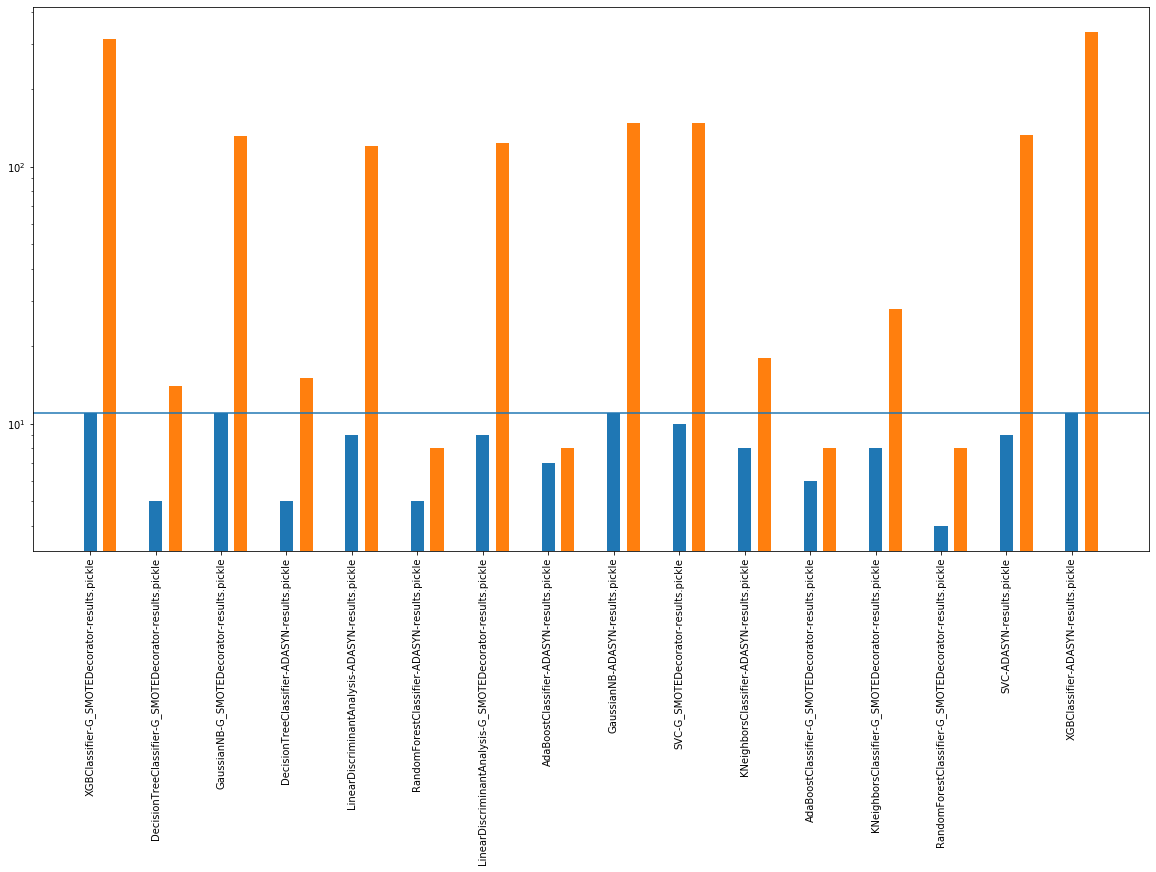

In [6]:
res_paths = glob('../experiments/feature_selection/results/*.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels, scores = [], [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name:
        with open(path, 'rb') as fh:
            res, y_true, y_pred = pickle.load(fh)
        res = pd.DataFrame(res)
        tps.append(sum(y_true & y_pred))
        ts.append(sum(y_pred))
        gts.append(sum(y_true))
        labels.append(path.name)
        scores.append(res.mean_test_score.max())
    else:
         with open(path, 'rb') as fh:
            print(pickle.load(fh))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))